### 2022 calculate size of mac marsh threshold areas
Regenerating results from 2018



**Date** August 2022

Import some useful modules

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
#from datacube.storage import masking
import os
#sys.path.append('../Scripts/')
#import dea_spatialtools
import pandas as pd
import numpy as np


In [2]:
import sys
sys.path.insert(1, '../Tools/')
import dea_tools.datahandling
from datacube.utils import masking
import dea_tools.spatial #hopefully this replaces dea_spatialtools

In [3]:
from datacube.utils.cog import write_cog

Load in the aerial raster

In [4]:
#open the aerial raster
aerial = xr.open_rasterio('/g/data/r78/rjd547/CEWO_Project/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/cewo_20160628_extents_again.tif')

#drop the empty dimension
aerial = aerial.squeeze()

process the aerial raster for comparison

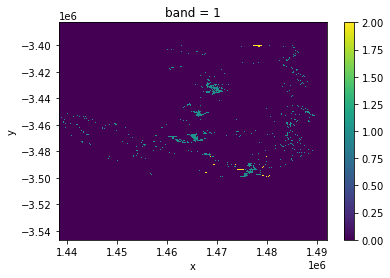

In [5]:
aerial.plot()
plt.show()

Notes: 0 is the nodata value, 1 is the wet value, and 2 is the storage value.

In [6]:
#remove the top row of our aerial raster as it does not overlap the thresholded rasters
aerial = aerial.where(aerial.y[0:6563])

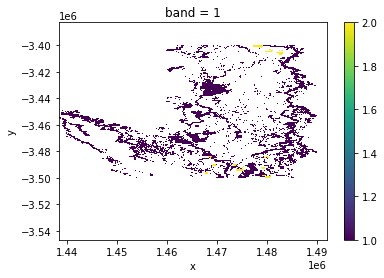

In [7]:
# remove nodata
aerial2=aerial.where(aerial!=65535.)
aerial2=aerial2.where(aerial!=-3.4028234663852886e+38)
aerial2=aerial2.where(aerial!=0)
aerial2.plot()
plt.show()

calculate the mapped area

In [8]:
aerialarea=np.round((aerial2.where(aerial2==1).count()*25*25)/(1000*1000),2)
print(aerialarea.values,'km^2') #note - this does not include storages. These are removed in the processing loop as they were not surveyed? 

99.27 km^2


In [9]:
#write this out as a cog
#write_cog(cewo_fix2, fname='/g/data/r78/rjd547/CEWO_Project/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/cewo_20160628_extents_2022b.tif')

## Build the loop to load our rasters and calculate our %coverage

thresholds are our chosen thresholds for the TCW; these need to match the filenames, and are not set here.

In [10]:
thresholds = ['-0','-50','-100','-150','-200','-250','-300','-350','-400','-450','-500','-550','-600']

make a dataframe to fill with our results

In [11]:
comparison_df_pixels = pd.DataFrame(columns=['TCW','notTCW','%ofwet','%ofdry'],index=thresholds)
comparison_df_area = pd.DataFrame(columns=['TCW km^2','notTCW km^2','%ofwet km^2', '%ofdrykm^2'],index=thresholds)

In [12]:
#make a list of the files corresponding to our set thresholds
thresholdFiles =[]
for i in range(0, len(thresholds)):
    #thresholdFiles.append('/g/data/r78/rjd547/CEWO_Project/MacquaThresholdDatarsh/bexnessresults/thresholded_wetness/clipped/t{0}_Mac_14_-35_20160627__20160629_clipped.tif'.format(thresholds[i]))
    thresholdFiles.append('/g/data/r78/rjd547/CEWO_Project/Macquarie_Marsh/bexnessresults/thresholded_wetness/2022/2022t{0}_Mac_14_-35_20160627__20160629.tif'.format(thresholds[i]))
    print ('threshold is ',thresholds[i])
    
    #open our thresholded TCW file    
    ThresholdData = xr.open_rasterio(thresholdFiles[i]) #thresholded TCW
    ThresholdData = ThresholdData.squeeze() #drop additional dimension of length 1
      
    #remove nodata vals around outside of map 
    ThresholdData=ThresholdData.where(ThresholdData!=-3.4028234663852886e+38)
    #count map area
    mapCount=ThresholdData.count()
    maparea=np.round((mapCount*25*25)/(1000*1000),2)
    print('total map area is',maparea.values,'km^2')
      
    #calculate wet and dry areas
    wetData=ThresholdData.where(ThresholdData==1)
    dryData=ThresholdData.where(ThresholdData==0)
    
    wetCount=wetData.count()
    wetarea=np.round((wetCount*25*25)/(1000*1000),2)
    print('wet count', wetCount.data, 'wetarea',wetarea.data,'km^2')
    
#   remove storages?
    noStwetData=wetData.where(aerial2.data!=2.0) #(not working at the moment?!)
    noStwetCount=noStwetData.where(noStwetData==1.).count()
    noStwetarea=np.round((noStwetCount*25*25)/(1000*1000),2)
    print('without storages',noStwetarea.values,'km^2')
    
# #     both = cewo_fix2.where(ThresholdData==1)
# #     bothCount = both.count()
#     #botharea=numpy.round((thresholdCount*25*25)/(1000*1000),2)
#     botharea=np.round((bothCount*25*25)/(1000*1000),2)
#     comparison_df_pixels.loc[thresholds[i]]=[thresholdCount.data, cewoCount.data, bothCount.data, np.round(((bothCount/cewoCount)*100).data,decimals=2)]
#     comparison_df_area.loc[thresholds[i]]=[thresholdarea.data, cewoarea.data, botharea.data, np.round(((botharea/cewoarea)*100).data,decimals=2)]
#     print(botharea)
#     plt.clf()
#     cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1)
#     ThresholdData.plot(cmap='viridis',vmin=0,vmax=1)
    #both.plot(cmap='Wistia',vmin=0,vmax=1)
    #plt.show()
    #print('ready to save plots')
    
#     %matplotlib inline
#     plt.clf()
#     fig = plt.figure(figsize=(10,11))
#     ax=plt.gca()
#     cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
#     ThresholdData.plot(cmap='Greens',vmin=0,vmax=3,alpha=0.7,add_colorbar=False)
#     #both.plot(cmap='winter',vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
    
#     #plt.title("TCW threshold "+thresholds[i])
#     ax.set_ylim((-3500000, -3400000))
#     print('ready to save plots')
#     #plt.savefig('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/plots2022/'+"2022TCW_threshold_"+thresholds[i]+100321'.png')
#     #plt.show()

threshold is  -0
total map area is 2750.8 km^2
wet count 51031 wetarea 31.89 km^2
without storages 27.98 km^2
threshold is  -50
total map area is 2750.8 km^2
wet count 58692 wetarea 36.68 km^2
without storages 32.73 km^2
threshold is  -100
total map area is 2750.8 km^2
wet count 67852 wetarea 42.41 km^2
without storages 38.41 km^2
threshold is  -150
total map area is 2750.8 km^2
wet count 78931 wetarea 49.33 km^2
without storages 45.29 km^2
threshold is  -200
total map area is 2750.8 km^2
wet count 92147 wetarea 57.59 km^2
without storages 53.51 km^2
threshold is  -250
total map area is 2750.8 km^2
wet count 108497 wetarea 67.81 km^2
without storages 63.68 km^2
threshold is  -300
total map area is 2750.8 km^2
wet count 129789 wetarea 81.12 km^2
without storages 76.94 km^2
threshold is  -350
total map area is 2750.8 km^2
wet count 159823 wetarea 99.89 km^2
without storages 95.68 km^2
threshold is  -400
total map area is 2750.8 km^2
wet count 199605 wetarea 124.75 km^2
without storages 1

In [13]:
# #make a list of the files corresponding to our set thresholds
# thresholdFiles =[]
# for i in range(0, len(thresholds)):
#     thresholdFiles.append('/g/data/r78/rjd547/CEWO_Project/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/t{0}_Mac_14_-35_20160627__20160629_clipped.tif'.format(thresholds[i]))
#     print (thresholdFiles[i])
    
#     ThresholdData = xr.open_rasterio(thresholdFiles[i]) #thresholded TCW
#     #count total pixels
#     totalcount = xr.open_rasterio(thresholdFiles[i]).count()
#     notarea = np.round((totalcount*25*25)/(1000*1000),2)
#     print(notarea)
#     ThresholdData=ThresholdData.where(ThresholdData!=-3.4028234663852886e+38)
#     ThresholdData=ThresholdData.where(ThresholdData!=0)
#     ThresholdData=ThresholdData.where(cewo_fix.data!=2.0)
#     thresholdCount=ThresholdData.where(ThresholdData==1.).count()
#     #thresholdarea=numpy.round((thresholdCount*25*25)/(1000*1000),2)
#     thresholdarea=np.round((thresholdCount*25*25)/(1000*1000),2)
#     both = cewo_fix2.where(ThresholdData==1)
#     bothCount = both.count()
#     #botharea=numpy.round((thresholdCount*25*25)/(1000*1000),2)
#     botharea=np.round((bothCount*25*25)/(1000*1000),2)
#     comparison_df_pixels.loc[thresholds[i]]=[thresholdCount.data, cewoCount.data, bothCount.data, np.round(((bothCount/cewoCount)*100).data,decimals=2)]
#     comparison_df_area.loc[thresholds[i]]=[thresholdarea.data, cewoarea.data, botharea.data, np.round(((botharea/cewoarea)*100).data,decimals=2)]
#     print(botharea)
# #     plt.clf()
# #     cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1)
# #     ThresholdData.plot(cmap='viridis',vmin=0,vmax=1)
# #     both.plot(cmap='Wistia',vmin=0,vmax=1)
# #     print('ready to save plots')
    
# #     %matplotlib inline
# #     plt.clf()
# #     fig = plt.figure(figsize=(10,11))
# #     ax=plt.gca()
# #     cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
# #     ThresholdData.plot(cmap='Greens',vmin=0,vmax=3,alpha=0.7,add_colorbar=False)
# #     both.plot(cmap='winter',vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
# #     plt.title("TCW threshold "+thresholds[i])
# #     ax.set_ylim((-3500000, -3400000))
# #     print('ready to save plots')
# #     #plt.savefig('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/plots2022/'+"3TCW_threshold_"+thresholds[i]+100321'.png')
# #     #plt.show()